Define functional categories and filter calls for those in Control and SCZ individuals

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import re
import attila_utils
import funcvar
import functools
import ensembl_rest
import os.path
from bsmcalls import SNPnexus
from bsmcalls import operations
from bsmcalls import resources
import statsmodels.api as sm
%matplotlib inline
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', -1)

## Preparations

Load data: annotated calls

In [2]:
data = SNPnexus.load_data('/home/attila/projects/bsm/results/2020-09-07-annotations/annotated-calls.p')

### GWAS genes

Here we take supplementary table 4 from the [CLOZUK paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5918692/) (clozapine UK), whose `Gene(s) tagged` column we turn into the `gwasgenes` set.

In [3]:
clozukpath = '/home/attila/projects/bsm/resources/CLOZUK/supp-table-4.csv'
gwasgenes = funcvar.get_geneset(df=pd.read_csv(clozukpath, skiprows=7), col='Gene(s) tagged')
print(len(gwasgenes), 'SCZ GWAS genes')

478 SCZ GWAS genes


### Brain expressed genes

#### RoadMap Epigenomics
`BRN.HIPP.MID` is the hippocampus of an adult whereas `BRN.FET.F` the brain of a female fetus (see [the RoadMap metadata](https://docs.google.com/spreadsheets/d/1yikGx4MsO9Ei36b64yOy9Vb6oPC5IBGlFbYEt-N6gOM/edit?usp=sharing)).

In [4]:
rna_roadmap = resources.read_roadmap_rna(sampledict={'E071': 'BRN.HIPP.MID', 'E082': 'BRN.FET.F'})
rna_roadmap

,BRN.HIPP.MID,BRN.FET.F
ENSG00000000003,35.083,53.039
ENSG00000000005,0.251,0.566
ENSG00000000419,26.467,29.927
ENSG00000000457,5.325,8.497
ENSG00000000460,1.487,3.408
...,...,...
ENSG00000259718,0.112,0.000
ENSG00000259741,38.850,45.583
ENSG00000259752,0.048,0.265
ENSG00000259765,0.000,0.000


The distribution of read counts is extremely skewed to the right, which makes it hard to assess correlation

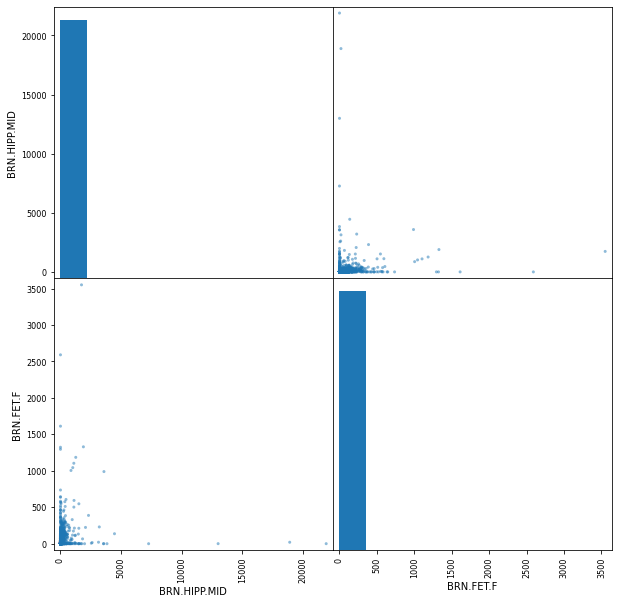

In [5]:
ax = pd.plotting.scatter_matrix(rna_roadmap, figsize=(10, 10))

The log readcount distribution is visually more informative.  There is a clear correlation between `BRN.HIPP.MID` and `BRN.FET.F`.

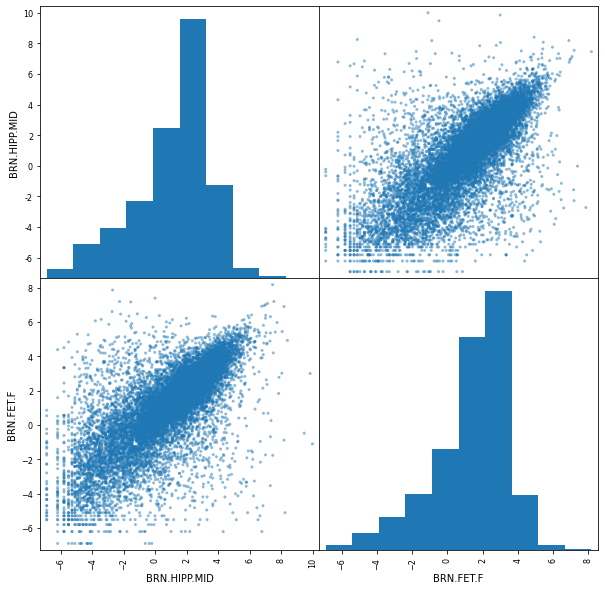

In [13]:
log_rna_roadmap = rna_roadmap.loc[~(rna_roadmap == 0).sum(axis=1).astype('bool')].apply(np.log)
rna = log_rna_roadmap
ax = pd.plotting.scatter_matrix(rna, figsize=(10, 10))

#### Protein Atlas
The [Human Protein Atlas](https://www.proteinatlas.org/humanproteome/brain/human+brain) contains several gene sets based on expression in the brain
1. `brain enriched`
1. `brain elevated`

In [14]:
pa_enriched = resources.read_proteinatlas_rna_brain('enriched')
pa_elevated = resources.read_proteinatlas_rna_brain('elevated')
print(len(pa_enriched), 'genes in the brain enriched set')
print(len(pa_elevated), 'genes in the brain elevated set')
pa_elevated

488 genes in the brain enriched set
2587 genes in the brain elevated set


,Gene,Gene synonym,Gene all names
Ensembl,,,
ENSG00000149452,SLC22A8,{OAT3},"{SLC22A8, OAT3}"
ENSG00000138136,LBX1,"{HPX6, LBX1H}","{HPX6, LBX1, LBX1H}"
ENSG00000131095,GFAP,{FLJ45472},"{GFAP, FLJ45472}"
ENSG00000164438,TLX3,"{HOX11L2, RNX}","{HOX11L2, TLX3, RNX}"
ENSG00000171532,NEUROD2,"{bHLHa1, NDRF}","{bHLHa1, NEUROD2, NDRF}"
...,...,...,...
ENSG00000172000,ZNF556,{FLJ11637},"{ZNF556, FLJ11637}"
ENSG00000173041,ZNF680,{FLJ90430},"{ZNF680, FLJ90430}"
ENSG00000182141,ZNF708,"{ZNF15L1, KOX8, ZNF15}","{ZNF15L1, KOX8, ZNF708, ZNF15}"


The following operations show that 123 genes in the `brain elevated` set of the Human Protein Atlas

In [15]:
print('protein_atlas_elevated AND NOT roadmap:', len(set(pa_elevated.index).difference(set(rna_roadmap.index))))
print('roadmap AND NOT protein_atlas_elevated:', len(set(rna_roadmap.index).difference(set(pa_elevated.index))))

protein_atlas_elevated AND NOT roadmap: 123
roadmap AND NOT protein_atlas_elevated: 17331


On the other hand, the `brain enriched` set (also from the Human Protein Atlas) is a proper subset of the `brain elevated` set.

In [16]:
set(pa_enriched.index).difference(set(pa_elevated.index))

set()

In [17]:
print('protein_atlas_elevated AND NOT log roadmap:', len(set(pa_elevated.index).difference(set(log_rna_roadmap.index))))
print('log roadmap AND NOT protein_atlas_elevated:', len(set(log_rna_roadmap.index).difference(set(pa_elevated.index))))

protein_atlas_elevated AND NOT log roadmap: 296
log roadmap AND NOT protein_atlas_elevated: 15736


(-8.0, 12.0)

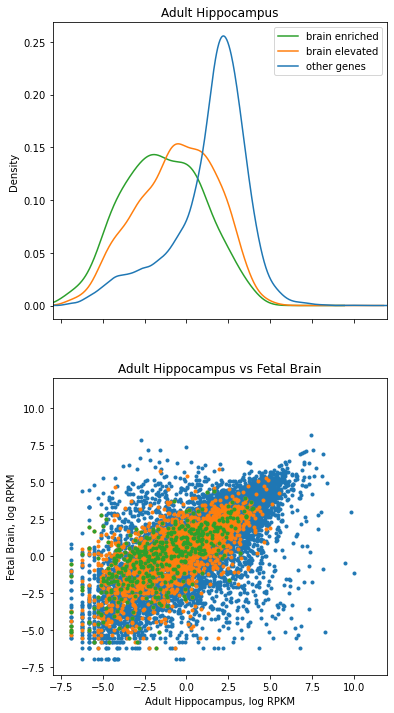

In [52]:
pa_enriched1 = pa_enriched.drop(set(pa_enriched.index).difference(set(log_rna_roadmap.index)))
log_rna_roadmap['brain enriched'] = False
log_rna_roadmap.loc[pa_enriched1.index, 'brain enriched'] = True
# Now the same for the brain elevated set
pa_elevated1 = pa_elevated.drop(set(pa_elevated.index).difference(set(log_rna_roadmap.index)))
log_rna_roadmap['brain elevated'] = False
log_rna_roadmap.loc[pa_elevated1.index, 'brain elevated'] = True
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 12), sharex=True, sharey=False)
ax[1].scatter(x='BRN.HIPP.MID', y='BRN.FET.F', color='C0', marker='.', data=rna.loc[~ rna['brain elevated']], label='other')
ax[1].scatter(x='BRN.HIPP.MID', y='BRN.FET.F', color='C1', marker='.', data=rna.loc[rna['brain elevated']], label='brain elevated')
ax[1].scatter(x='BRN.HIPP.MID', y='BRN.FET.F', color='C2', marker='.', data=rna.loc[rna['brain enriched']], label='brain enriched')
ax[1].set_title('Adult Hippocampus vs Fetal Brain')
ax[1].set_xlabel('Adult Hippocampus, log RPKM')
ax[1].set_ylabel('Fetal Brain, log RPKM')
ax[1].set_xlim(-8, 12)
ax[1].set_ylim(-8, 12)
# Adult hippocampus
rna.loc[rna['brain enriched'], 'BRN.HIPP.MID'].plot(kind='kde', color='C2', ax=ax[0], label='brain enriched')
rna.loc[rna['brain elevated'], 'BRN.HIPP.MID'].plot(kind='kde', color='C1', ax=ax[0], label='brain elevated')
rna.loc[~ rna['brain elevated'], 'BRN.HIPP.MID'].plot(kind='kde', color='C0', ax=ax[0], label='other genes')
ax[0].legend()
ax[0].set_title('Adult Hippocampus')
ax[0].set_xlabel('gene expression, log RPKM')
ax[0].set_xlim(-8, 12)

Kernel density estimates for the female fetal brain

Text(0.5, 0, 'gene expression, log RPKM')

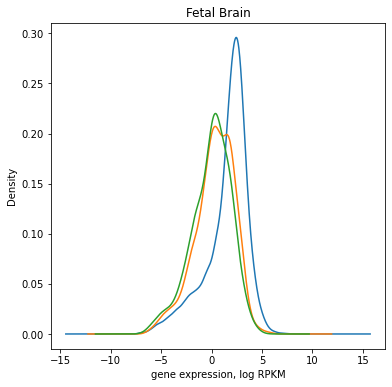

In [41]:
fig, ax = plt.subplots(figsize=(6, 6), sharex=False, sharey=False)
rna.loc[~ rna['brain elevated'], 'BRN.FET.F'].plot(kind='kde', color='C0', ax=ax, label='brain enriched')
rna.loc[rna['brain elevated'], 'BRN.FET.F'].plot(kind='kde', color='C1', ax=ax, label='brain elevated')
rna.loc[rna['brain enriched'], 'BRN.FET.F'].plot(kind='kde', color='C2', ax=ax, label='other genes')
ax.legend()
ax.set_title('Fetal Brain')
ax.set_xlabel('gene expression, log RPKM')

## Results: calls in functional categories
### Among all calls

In [ ]:
# near_gens
queryitems = ['coding nonsyn', 'missense', 'stop-gain', 'intronic (splice_site)']
df = operations.query(queryitems, feature='near_gens_Annotation', data=data)
df['Dx'] = data['Dx']
df.groupby('Dx').sum().T

In [ ]:
# near_gens
querydict = {'near_gens_Annotation': ['coding nonsyn', 'missense', 'stop-gain', 'intronic (splice_site)'],
             'sift_Prediction': ['Deleterious', 'Deleterious - Low Confidence'],
             'polyphen_Prediction': ['Probably Damaging', 'Possibly Damaging'],
             'tfbs_TFBS Name': None,
             'phast_Score': None,
             'gerp_Element RS Score': None,
             'cpg_CpG Island': None,
             'near_gens_Overlapped Gene': {'SCZ GWAS genes': gwasgenes},
            }
results = operations.multiquery(querydict, data, do_sum=False, do_sort=False, margin=True)
operations.summarize_query_results(results, data, margin=True)

### Among calls in SCZ GWAS genes
Now first filter for SNVs in SCZ GWAS genes and repeat the calculations

In [ ]:
s = results[('near_gens_Overlapped Gene', 'SCZ GWAS genes')]
l = [results[x] & s for x in results.iloc[:, :-2]]
df = pd.concat(l, axis=1)
df = pd.DataFrame(df.to_numpy(), index=df.index, columns=results.columns[:-2])
operations.summarize_query_results(df, data, margin=True)

## Continuous variables

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
ax[0].scatter(x='cadd_Raw Score', y='cadd_PHRED', marker='+', data=data)
data['cadd_Raw Score'].hist(ax=ax[1])
attila_utils.savefig(fig, 'cadd')

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
ax[0].scatter(x='eigen_Score', y='eigen_PC Score', marker='+', data=data)
data['eigen_Score'].hist(ax=ax[1])
ax[0].set_xlabel('eigen_Score')
ax[0].set_ylabel('eigen_PC Score')
ax[1].set_xlabel('eigen_Score')
attila_utils.savefig(fig, 'eigen')

In [ ]:
cols = [c for c in data.columns if re.match('^deepsea.*', c)]
ax = pd.plotting.scatter_matrix(data[cols], figsize=(10, 10))
attila_utils.savefig(fig, 'deepsea-corrmat-scatter')

In [ ]:
def corrmatplot(dfnum):
    corrmat = dfnum.corr()
    fig, ax = plt.subplots(figsize=(6, 6))
    sm.graphics.plot_corr(corrmat, ax=ax, xnames=dfnum.columns, ynames=dfnum.columns)
    cb = plt.colorbar(ax.get_images()[0])
    cb.set_label('Correlation')
    return((fig, ax))

corrmatplot(data[cols])
attila_utils.savefig(fig, 'deepsea-corrmat-image')

In [ ]:
%matplotlib inline
cols = ['cadd_Raw Score', 'fitcons_Fitness Score', 'eigen_Score', 'fathmm_Non-coding Score', 'deepsea_Functional Significance Score', 'funseq2_Non-coding Score', 'remm_ReMM Score']
ax = pd.plotting.scatter_matrix(data[cols], figsize=(12, 12))
attila_utils.savefig(fig, 'selected-noncoding-corrmat-scatter')

In [ ]:
corrmatplot(data[cols])
attila_utils.savefig(fig, 'selected-noncoding-corrmat-image')

In [ ]:
corrmatplot(data.loc[:, 'cadd_Raw Score':'remm_ReMM Score'].select_dtypes('float64'))
attila_utils.savefig(fig, 'all-noncoding-corrmat-image')

### Functional variants

First let's see Taejeong's definition of functional variants

> The terms that we chose as functional are missense, stop_gained, splice_region, regulatory, and TF_binding.

### Outlier individual

In [ ]:
# TODO
#D.loc[funcAby, sel_cols].loc['CMC_MSSM_224']

In [ ]:
%connect_info